# **News Headline Classification with GPT-2**

This Jupyter Notebook presents a detailed workflow for classifying news headlines using the GPT-2 model, a powerful transformer-based model renowned for its text generation capabilities. The project's aim is to categorize news headlines into distinct topics, facilitating easier navigation and retrieval of news content. The notebook encompasses the entire process, from data preparation and preprocessing to fine-tuning the GPT-2 model and evaluating its performance. The approach takes advantage of the pre-trained GPT-2 to understand the context and nuances within the headlines, striving to achieve a high-accuracy classification system that could be a valuable tool in managing and sorting through news data.

## **Setting Up the Environment**
This cell is responsible for installing necessary Python packages to set up the working environment.


In [1]:
! pip install datasets transformers torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━

## **Importing Necessary Libraries and Modules**

In this section, we import all the necessary libraries and modules required for our News Headline Classification with GPT-2 project.

In [2]:
import argparse
import json
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from tqdm import tqdm

from transformers import (AutoModelForSequenceClassification, DataCollatorWithPadding,
                          GPT2Model, GPT2Tokenizer, Trainer, TrainingArguments)

## **Mounting Google Drive**

Mount the Google Drive to load the dataset and any other resources stored in the drive. Navigate to the folder where dataset is stored.

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading and Displaying the Dataset**

In this cell, we load the news classification dataset from a JSON file into a pandas DataFrame, which provides a tabular representation of the data. The dataset, presumably named 'News_Category_Dataset_v3.json', contains news headlines and their corresponding categories. After loading, we display the total number of rows and columns to understand the dataset's size. Finally, the head() function is used to output the first few entries of the dataset, giving us a glimpse into the structure and content of the news data we will be working with.



In [4]:
df = pd.read_json('/content/drive/My Drive/News_Category_Dataset_v3.json', lines=True)
print('No. of rows and columns :', df.shape)
df.head()

No. of rows and columns : (209527, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


## **Visualizing the Distribution of News Categories**

This cell focuses on analyzing the distribution of news articles across different categories in the dataset. We first create a new DataFrame called count_df that aggregates the number of news articles by category, using the value_counts() method. This gives us a clear idea of how many news articles are available per category. We print out the total number of unique news categories for clarity.

There are 42 news categories


<ipython-input-5-a6f810b68069>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count_df, y='index', x='category', palette='Dark2')


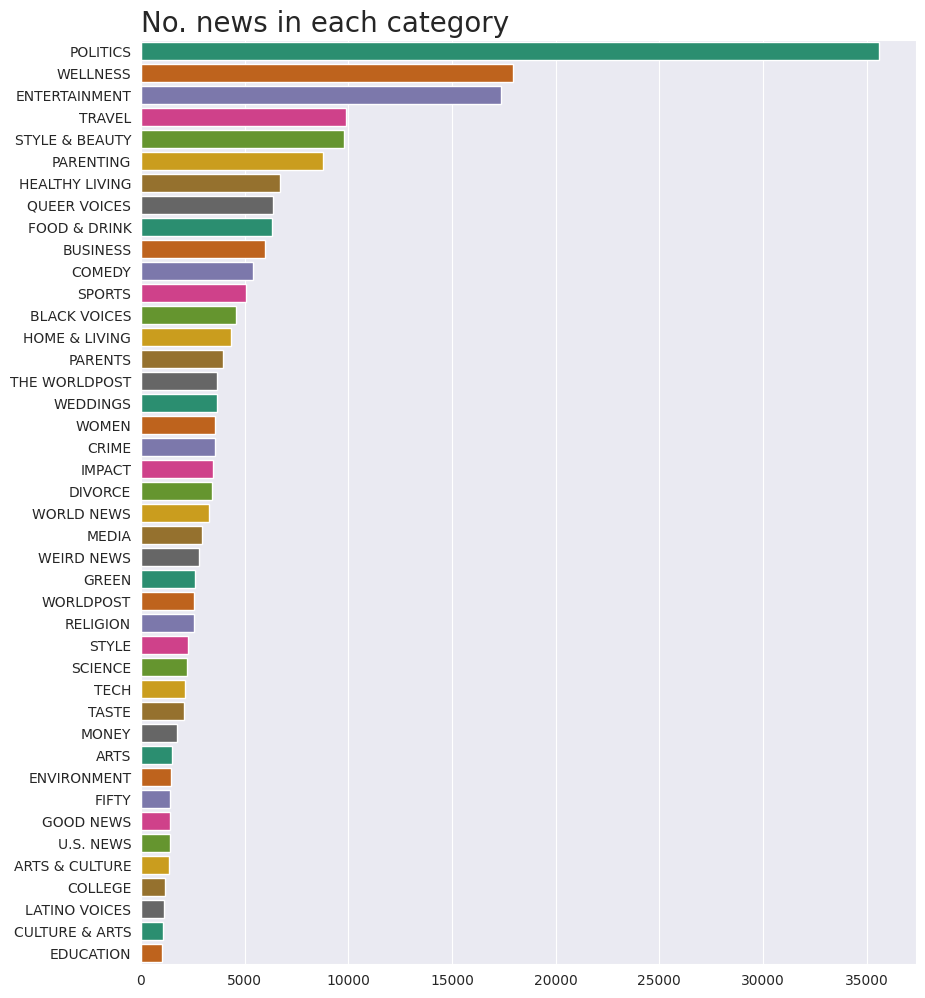

In [5]:
count_df = pd.DataFrame(df['category'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='index', x='category', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

## **Initialization of the Tokenizer for Text Processing**

This cell sets up the tokenizer that will be used for processing the text data. We initialize the GPT2Tokenizer from the transformers library, which is specifically designed to work with the GPT-2 model. The tokenizer is configured to pad sequences from the left side to maintain consistency with GPT-2's expected input format. Additionally, the end-of-string token (eos_token) is assigned as the padding token, ensuring that padded inputs are treated appropriately during model training and inference. This step is crucial for preparing the text data for subsequent processing stages, such as encoding the headlines into a format that can be processed by the neural network.

In [6]:
# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token  # Set pad token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [7]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [8]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [9]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


## **Defining a Stopwords List for Text Cleaning**

In this cell, we define a list of common English stopwords sourced from a reputable SEO tool's GitHub repository. Stopwords are words which are commonly removed from text data before processing in natural language tasks as they often carry little informational weight. This list includes pronouns, conjunctions, prepositions, and other words that are frequently used in the English language, but are typically not useful for understanding the context or sentiment of a text. By defining this list, we can preprocess and clean our news headline data to enhance the performance of the classification model by focusing on the most meaningful words.

In [10]:
# Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

## **Balancing the Dataset Across Categories**

In this cell, we address potential class imbalance by creating a more balanced dataset. For each unique category in our dataset, we subset the DataFrame to include only the data from that category. From each subset, we randomly sample a fixed number of entries (1004 in this case, which is chosen to match the size of the smallest class or for another specific reason). All these balanced subsets are then stored in a list.

In [11]:
dfs = []

for category in df['category'].unique():
    temp = df[df['category']==category]
    dfs.append(temp.sample(1004))

df = pd.concat(dfs)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/dessert-d...,Dessert Dumpling Recipes (PHOTOS),FOOD & DRINK,"Put the pork, shrimp and vegetables aside.",,2013-09-17
1,https://www.huffingtonpost.com/entry/egypt-pre...,'El-Sissi Got Handed The Country On A Silver P...,WORLDPOST,,Sophia Jones,2014-05-26
2,https://www.huffingtonpost.com/entry/gunfight-...,Gunfight At The Second Amendment Corral,POLITICS,Like it or not the Second Amendment exists and...,"David Schultz, ContributorProfessor of Politic...",2017-10-07
3,https://www.huffingtonpost.com/entry/barbuda-s...,Barbuda Sets a New Standard for Marine Protect...,GREEN,Earlier this week the Barbuda Council signed i...,"Amber Jackson, ContributorOceanographer, envir...",2014-08-16
4,https://www.huffingtonpost.com/entry/perfume-f...,Finding Your Perfect Scent,STYLE & BEAUTY,The most important thing to remember when shop...,"Lev Glazman, Contributor\nCo-Founder, Fresh",2013-02-15


## **Preprocessing Headlines: Cleaning and Stopwords Removal**

This cell introduces two functions essential for preprocessing the text data, making it more suitable for model training and analysis:

alpha_num(text): This function removes all characters from the input text that are not alphanumeric (letters and numbers) or spaces. It does this by using a regular expression that matches any character not in the set of uppercase letters, lowercase letters, digits, or space, and replaces them with an empty string. This cleaning step is crucial for standardizing the text data and focusing the model's attention on meaningful words and numbers.

remove_stopwords(text): The second function takes a string of text as input and filters out any words that are present in the predefined list of stopwords. It splits the text into individual words, checks each word against the stopwords list, and reassembles the text from the words not found in the list. Removing stopwords helps in reducing the noise within the data, allowing models to focus on the words that carry significant meaning or sentiment.

Together, these functions streamline the dataset by removing irrelevant characters and words, thereby improving the efficiency and performance of subsequent natural language processing tasks.






In [12]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

In [13]:
df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].apply(alpha_num)
df['headline'] = df['headline'].apply(remove_stopwords)

df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/dessert-d...,dessert dumpling recipes photos,FOOD & DRINK,"Put the pork, shrimp and vegetables aside.",,2013-09-17
1,https://www.huffingtonpost.com/entry/egypt-pre...,elsissi got handed country silver platter,WORLDPOST,,Sophia Jones,2014-05-26
2,https://www.huffingtonpost.com/entry/gunfight-...,gunfight second amendment corral,POLITICS,Like it or not the Second Amendment exists and...,"David Schultz, ContributorProfessor of Politic...",2017-10-07
3,https://www.huffingtonpost.com/entry/barbuda-s...,barbuda sets new standard marine protection ca...,GREEN,Earlier this week the Barbuda Council signed i...,"Amber Jackson, ContributorOceanographer, envir...",2014-08-16
4,https://www.huffingtonpost.com/entry/perfume-f...,finding perfect scent,STYLE & BEAUTY,The most important thing to remember when shop...,"Lev Glazman, Contributor\nCo-Founder, Fresh",2013-02-15


## **Narrowing Down to Selected News Categories**

In this cell, we define and apply the filter_categories function to refine our dataset to include only news headlines from five specific categories: 'POLITICS', 'WELLNESS', 'TRAVEL', 'BUSINESS', and 'ENTERTAINMENT'. This step is crucial for focusing the model's training and evaluation on a subset of categories that are of particular interest or relevance to our project goals. By filtering the dataset in this manner, we ensure that the subsequent modeling efforts are concentrated on distinguishing between these chosen topics, potentially improving the model's performance in these areas due to a more targeted approach. After applying the filter, the dataset is updated to contain only the entries belonging to the specified categories, streamlining the data for the next stages of preprocessing and model training.

In [14]:
def filter_categories(df, categories_to_keep):
    """
    Filters the DataFrame to keep only the rows with the specified categories.

    Parameters:
    - df (pandas.DataFrame): The original DataFrame.
    - categories_to_keep (list of str): The list of categories to retain.

    Returns:
    - pandas.DataFrame: A DataFrame with only the rows of the specified categories.
    """
    return df[df['category'].isin(categories_to_keep)]

# Define the categories to keep
categories_to_keep = ['POLITICS', 'SPORTS', 'TECH', 'BUSINESS', 'ENTERTAINMENT']

df = filter_categories(df, categories_to_keep)

## **Ensuring Data Quality by Removing Empty Headlines**

This cell is dedicated to further cleaning the dataset by removing any rows where the 'headline' field is either null or consists only of whitespace. Such entries are uninformative for the purposes of text classification and can negatively impact the model's training and evaluation phases by introducing noise. By applying a condition that retains only those rows with non-null and non-empty 'headline' fields, we enhance the overall data quality. This step is a crucial part of data preprocessing to ensure that the dataset fed into the model is as clean and meaningful as possible, laying a strong foundation for effective machine learning.

In [15]:
df = df[df['headline'].notnull() & (df['headline'].str.strip() != '')]

## **Identifying Unique News Categories in the Filtered Dataset**

In [16]:
# unique news category
df['category'].unique()

array(['POLITICS', 'SPORTS', 'TECH', 'ENTERTAINMENT', 'BUSINESS'],
      dtype=object)

## **Creating a Custom Dataset for News Headline Classification**

This cell establishes a custom Dataset class for handling the news headlines dataset within the PyTorch framework. The class is designed to facilitate the training and evaluation of our model by organizing the data into a format that's compatible with PyTorch's DataLoader.

**Label Encoding:** A dictionary named labels maps each news category to a unique integer. This encoding is essential for converting categorical labels into a format that the model can understand and process.

**Initialization:** The __init__ method takes the DataFrame df as input. It then creates two lists: self.labels, which stores the encoded labels for each headline, and self.texts, which contains the tokenized and encoded versions of the headlines. During tokenization, we ensure that each headline is padded or truncated to a uniform length of 128 tokens, and we check for any empty inputs, which could indicate an issue with preprocessing.

**Utility Methods:** The class includes several utility methods such as classes to return the list of labels, __len__ to get the dataset size, get_batch_labels and get_batch_texts for retrieving batches of labels and texts, and __getitem__ to fetch a specific sample by index. The __getitem__ method is particularly important as it ensures the dataset can be iterated over by a DataLoader, returning both the tokenized text and its corresponding label in a format ready for model training or evaluation.

This custom dataset class is a critical component of the machine learning pipeline, allowing for efficient data handling and preprocessing that is tailored to the specific needs of our news headline classification task with GPT-2.

In [17]:
labels = {category: i for i, category in enumerate([
    'POLITICS', 'SPORTS', 'TECH', 'ENTERTAINMENT', 'BUSINESS'])}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['headline']]
        for i, enc in enumerate(self.texts):
            if enc['input_ids'].size(1) == 0:
                print(f"Empty input at index: {i}, text: {df.iloc[i]['headline']}")


    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## **Splitting the Dataset into Training, Validation, and Test Sets**

This cell is responsible for dividing the preprocessed dataset into three distinct subsets: training, validation, and test sets. The division is crucial for training the model effectively, validating its performance during training, and finally evaluating its generalization ability on unseen data.

In [18]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

4016 502 502


## **Defining GPT-2 Based Sequence Classifier**

This cell introduces a custom neural network class, which extends PyTorch's nn.Module. This class is designed to perform sequence classification tasks by leveraging the pre-trained GPT-2 model as a feature extractor and adding a linear layer on top for the classification. The model architecture is tailored for classifying text sequences, such as news headlines, into predefined categories.

In [21]:
class GPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(GPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## **Training and Evaluating the GPT-2 Classifier**

This cell outlines the training loop for our GPT-2 sequence classifier. Here's how the process works:

**Data Preparation:** We create Dataset objects for both training and validation data, which are then loaded into DataLoaders to handle batching and shuffling.

**Model and Training Setup:** We initialize our custom GPT-2 classifier, specify the loss function (CrossEntropyLoss for classification), and choose an optimizer (Adam with a predefined learning rate). We also check for CUDA availability to use GPU acceleration if possible.

**Training Loop:** For each epoch, we iterate over the training data, performing forward passes, calculating loss, and updating the model parameters. We also track training accuracy and loss to monitor the learning process.

**Validation:** After each epoch, we evaluate the model on the validation set to monitor its performance on unseen data, helping us to avoid overfitting.
The training and validation accuracies and losses are printed at the end of each epoch, providing insights into the model's learning progress and helping us to fine-tune our training strategy.

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 1
model = GPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)


## **Evaluating the GPT-2 Classifier on Test Data**

This cell outlines the process for evaluating the trained GPT-2 sequence classifier on the test dataset. The purpose of this evaluation is to assess the model's performance on unseen data, providing a more accurate measure of its ability to generalize.

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

## **Visualizing Model Performance with a Confusion Matrix**

This cell is dedicated to visualizing the performance of our GPT-2 sequence classifier using a confusion matrix. A confusion matrix is a powerful tool for understanding how well the model performs across different categories, providing insights into which classes are correctly identified and where misclassifications occur.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## **Saving the Trained Model**

After training and evaluating the GPT-2 sequence classifier, this cell saves the model's parameters to a file, ensuring that the trained model can be loaded and used later without needing to retrain from scratch. The torch.save function is used to save the model's state dictionary to a specified file path on Google Drive. This saved model file can then be easily loaded in future sessions or used in different environments, facilitating model deployment or further experimentation. Saving the model is an essential step in the machine learning workflow, providing a way to preserve the model's learned weights and biases after training.



In [26]:
torch.save(model.state_dict(), "/content/drive/My Drive/gpt2-text-classifier-model.pt")

## **Loading and Preparing the Trained Model for Inference**

This cell demonstrates how to load the previously saved GPT-2 sequence classifier model for inference or further evaluation.

In [27]:
model_new = GPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("/content/drive/My Drive/gpt2-text-classifier-model.pt"))
model_new.eval()

GPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=5, bias=True)
)

## **Model Inference**

In this cell, we prepare a sample piece of text for inference using our trained GPT-2 sequence classifier. The goal is to process the example text so it matches the format expected by the model, allowing us to predict its category.

In [29]:
example_text = """
  journalisms challenge unending state emergency
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

journalisms challenge unending state emergency


## **Making a Prediction with the Trained Model**

In this cell, we proceed to use the trained GPT-2 sequence classifier, model_new, to make a prediction on the preprocessed and tokenized example text.

In [30]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [31]:
print(output)

tensor([[ 2.5765, -1.5517, -0.9494, -0.8112, -0.0631]],
       grad_fn=<AddmmBackward0>)


## **Generating Prediction and Probability Distribution**

This section of the code is focused on making a prediction using the previously loaded model_new with the prepared input text.

In [32]:
prob = torch.nn.functional.softmax(output, dim=1)[0]
print(prob)

tensor([0.8690, 0.0140, 0.0256, 0.0294, 0.0620], grad_fn=<SelectBackward0>)


## **Interpreting the Model's Predicted Category**

After obtaining the probability distribution for the example text's classification, this cell focuses on interpreting the model's prediction to understand the specific category it has identified for the input text.

In [34]:
labels_to_ids = {category: i for i, category in enumerate([
    'POLITICS', 'SPORTS', 'TECH', 'ENTERTAINMENT', 'BUSINESS'
])}

# Create a dictionary to map numeric labels to category names
ids_to_labels = {i: category for category, i in labels_to_ids.items()}

pred_label = ids_to_labels[output.argmax(dim=1).item()]
print(pred_label)

POLITICS


## **Displaying Sample Headlines and Categories from the Test Dataset**

In this final step of our workflow, we showcase a practical application of our data by displaying a small sample of news headlines along with their true categories from the test dataset. This serves not only as a demonstration of the kind of data the model has been evaluated on but also provides a glimpse into the real-world scenarios where the model's predictions are expected to perform. By iterating over the first five entries of the df_test DataFrame, we extract and print both the headline and its associated category, clearly illustrating the diversity and complexity of the classification task at hand.



In [25]:
# Print the first 5 headlines and their categories from the test dataset
for index, row in df_test.head().iterrows():
    print(f"Headline: {row['headline']}, Category: {row['category']}")


Headline: journalisms challenge unending state emergency, Category: POLITICS
Headline: watch dustin hoffman smooch judi dench kiss cam, Category: ENTERTAINMENT
Headline: payday lender blocked access customer accounts lawsuit claims, Category: BUSINESS
Headline: top 10 youtube channels leaders, Category: BUSINESS
Headline: personal arcs equating professional success, Category: ENTERTAINMENT
